In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook, plots are configured to be rendered as images because otherwise they won't display correctly on GitHub or when the notebook is loaded (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook.


# Temperature forecasting with LSTM and probabilistic calibration

This notebook showcase the probabilistic calibration of [Timeseria](https://github.com/sarusso/Timeseria), applied to a LSTM forecaster.

Let's start by loading an example time series, and resample it to one hour:

In [2]:
from timeseria import TEST_DATASETS_PATH
from timeseria.datastructures import TimeSeries
timeseries = TimeSeries.from_csv(TEST_DATASETS_PATH + 'temperature.csv').resample('1h')
timeseries.change_tz('Europe/Rome')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Resampled 18331 DataTimePoints in 3189 DataTimePoints


Have a look at the time series we just loaded:

In [3]:
timeseries

Time series of #3189 points at 1h resolution, from point @ 1546480800.0 (2019-01-03 03:00:00+01:00) to point @ 1557957600.0 (2019-05-16 00:00:00+02:00)

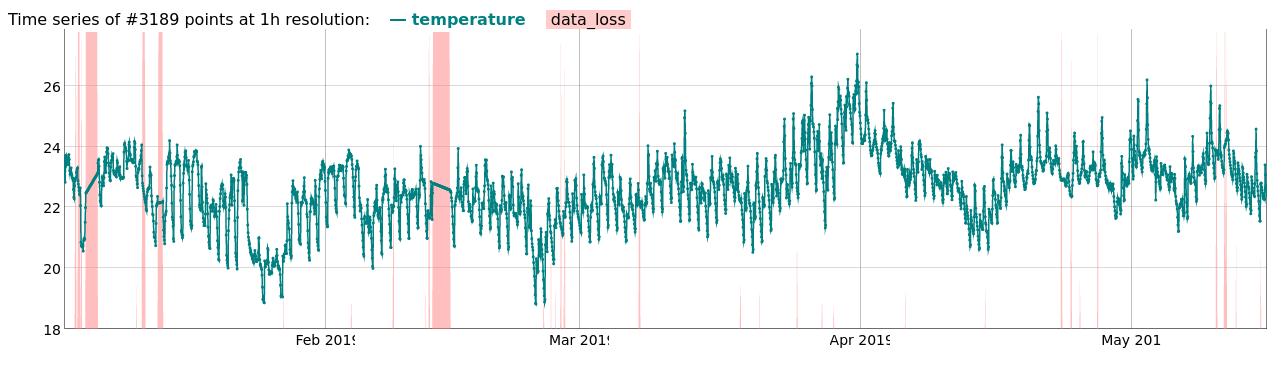

In [4]:
timeseries.plot()

Define the training, calibration and test datasets, keeping in mind that both the training and clibration datasets will be further sub-divided in train/calibration and validation splits:

In [5]:
train_timeseries = timeseries[0:1500]
calibration_timeseries = timeseries[1500:2500]
test_timeseries = timeseries[2500:3189]

Instantiate and fit the LTSM forecasting model:

In [6]:
from timeseria.models import LSTMForecaster
forecaster = LSTMForecaster(window=24, neurons=256, features=['values', 'hours'])
forecaster.fit(train_timeseries, epochs=30, validation_split=0.2, reproducible=True, verbose=False)

## Error quantile-based calibration

This calibration technique computes the error quantiles and then uses them to provide calibrated prediction intervals with a predefined coverage level, which are represented using the IFloat (Interval Float) type.

By default, it uses an alpha of 0.1 (corresponding to a confidence level of 0.9), and thus computes the 0.05 and 0.95 quantiles.

This is the standard approach for conformal prediction in time series forecasting.

In [7]:
from timeseria.models.calibrators import ErrorQuantileCalibrator
forecaster.calibrate(calibration_timeseries,
                     ErrorQuantileCalibrator,
                     error_metric='AE')

[INFO] timeseria.models.base: Calibrating model using "ErrorQuantileCalibrator"
[INFO] timeseria.models.calibrators: Fitting calibrator using "AE" error metric and "0.1" alpha


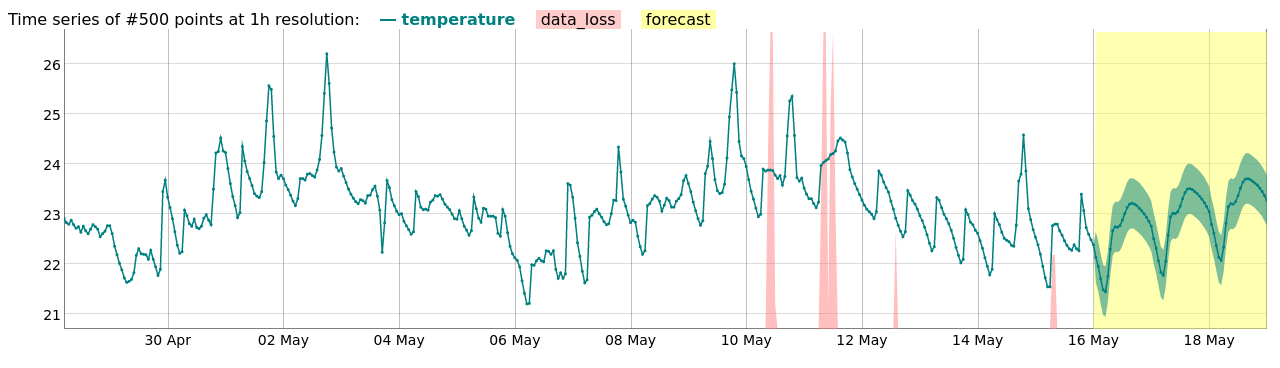

In [8]:
forecaster.apply(timeseries, steps=24*3)[-500:].plot()

Let’s now evaluate this calibration on both the calibration and the test datasets:

In [9]:
evaluation = forecaster.evaluate(calibration_timeseries, verbose=True)
print(f"Empirical coverage @ 0.9: {evaluation['temperature_EC']}")

Evaluating for "temperature": .........
Empirical coverage @ 0.9: 0.8995901639344263


In [10]:
evaluation = forecaster.evaluate(test_timeseries, return_evaluation_series=True, verbose=True)
print(f"Empirical coverage @ 0.9: {evaluation['temperature_EC']}")

Evaluating for "temperature": .........
Empirical coverage @ 0.9: 0.9142857142857143


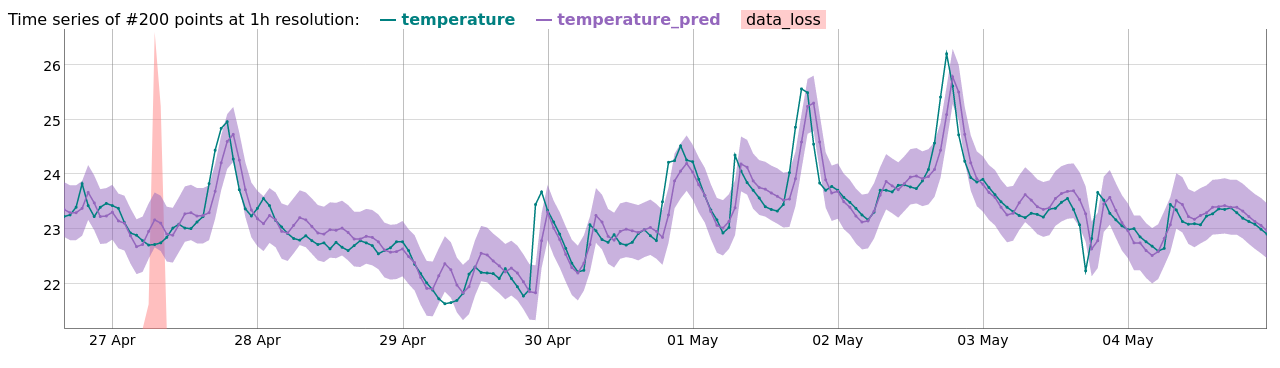

In [11]:
evaluation['series'][200:400].plot(data_labels=['temperature', 'temperature_pred'])

## Error distribution-based calibration

This technique computes the global error distribution and then uses it to construct a full probabilistic prediction in the form of a probability distribution, represented using the PFloat (Probabilistic Float) type.

In [12]:
from timeseria.models.calibrators import ErrorDistributionCalibrator
forecaster.calibrate(calibration_timeseries,
                     ErrorDistributionCalibrator,
                     error_metric='AE',
                     error_distribution='norm')

[WARNING] timeseria.models.base: This model is already calibrated. Re-calibrating it will drop the previous calibration.
[INFO] timeseria.models.base: Calibrating model using "ErrorDistributionCalibrator"
[INFO] timeseria.models.calibrators: Fitting calibrator using "AE" error metric and "norm" error distribution


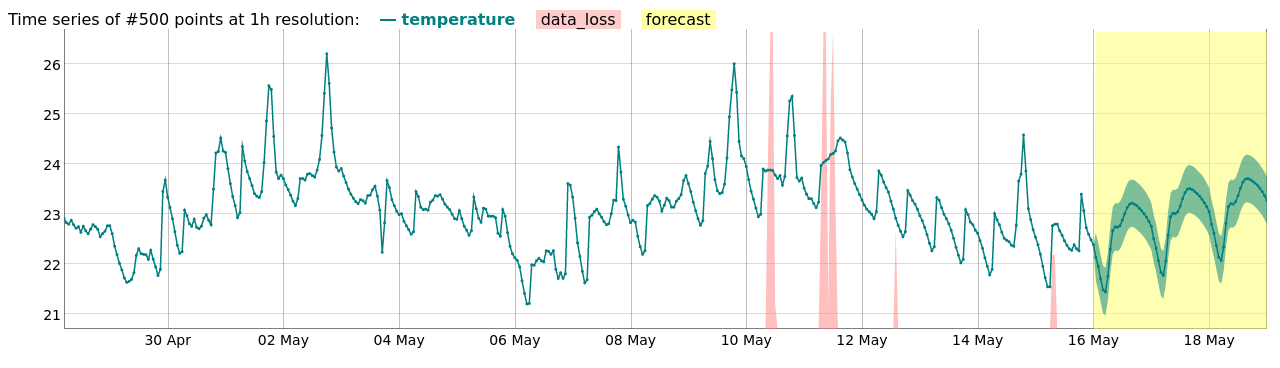

In [13]:
forecaster.apply(timeseries, steps=24*3)[-500:].plot()

Let’s now evaluate this calibration on both the calibration and the test datasets:

In [14]:
evaluation = forecaster.evaluate(calibration_timeseries, verbose=True)
print(f"Empirical coverage @ 0.9: {evaluation['temperature_EC']}")

Evaluating for "temperature": .........
Empirical coverage @ 0.9: 0.8842213114754098


In [15]:
evaluation = forecaster.evaluate(test_timeseries, return_evaluation_series=True, verbose=True)
print(f"Empirical coverage @ 0.9: {evaluation['temperature_EC']}")

Evaluating for "temperature": .........
Empirical coverage @ 0.9: 0.9037593984962407


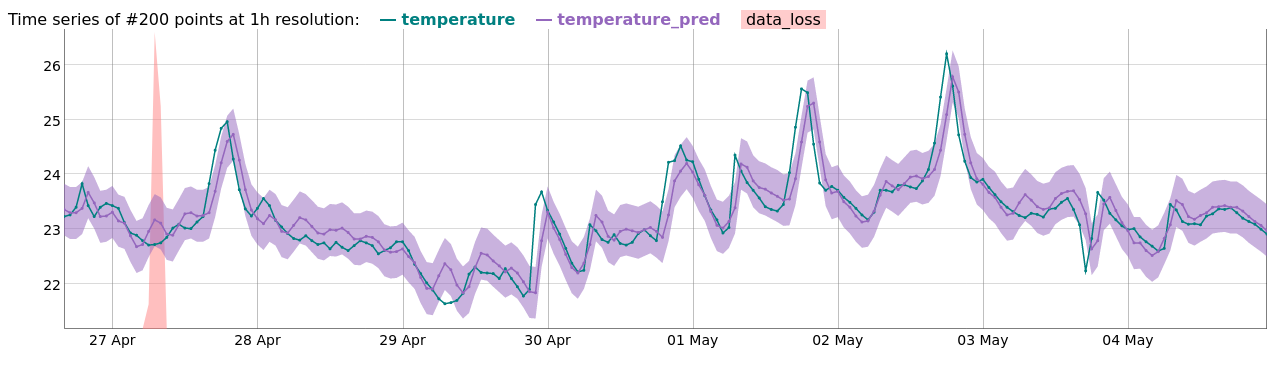

In [16]:
evaluation['series'][200:400].plot(data_labels=['temperature', 'temperature_pred'])

## Error prediction-based calibration

This calibrator makes use of an error predictor which takes as input the same input of the model being calibrated (i.e. the forecasting window), thus allowing to adapt the uncertainty estimates to the local context.

Uncertainty is then expressed with a Normal distribution computed by reversing the expected absolute error formula with respect to the standard deviation, using the PFloat (Probabilistic Float) type.

In [17]:
from timeseria.models.calibrators import ErrorPredictionCalibrator
forecaster.calibrate(calibration_timeseries,
                     ErrorPredictionCalibrator,
                     error_predictor_neurons=256,
                     error_predictor_features=['values', 'hours'],
                     error_predictor_fit_epochs=100,
                     error_predictor_fit_validation_split=0.2,
                     error_predictor_fit_reproducible=True,
                     error_predictor_fit_verbose=False)

[WARNING] timeseria.models.base: This model is already calibrated. Re-calibrating it will drop the previous calibration.
[INFO] timeseria.models.base: Calibrating model using "ErrorPredictionCalibrator"
[INFO] timeseria.models.calibrators: Fitting calibrator using "LSTMForecaster" error predictor with "AE" metric


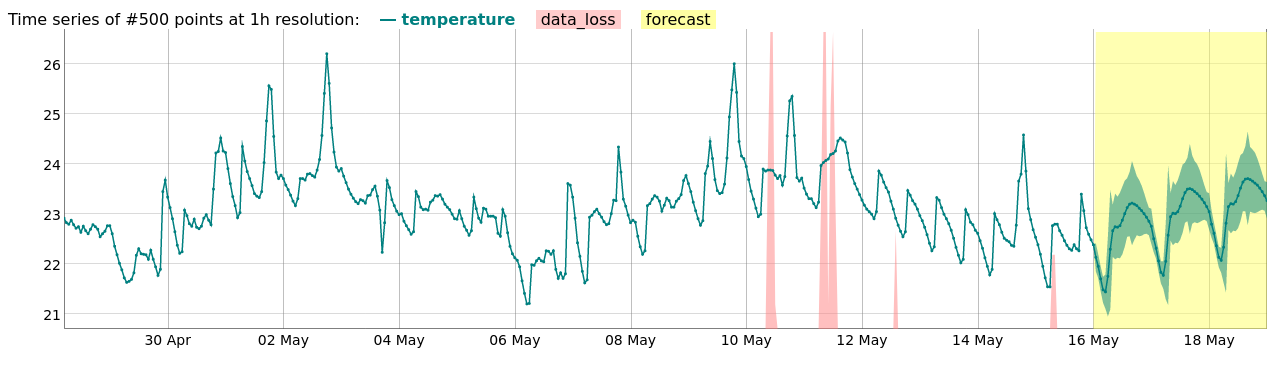

In [18]:
forecaster.apply(timeseries, steps=24*3)[-500:].plot()

Let’s now evaluate this calibration on both the calibration and the test datasets:

In [19]:
evaluation = forecaster.evaluate(calibration_timeseries, verbose=True)
print(f"Empirical coverage @ 0.9: {evaluation['temperature_EC']}")

Evaluating for "temperature": .........
Empirical coverage @ 0.9: 0.951844262295082


In [20]:
evaluation = forecaster.evaluate(test_timeseries, return_evaluation_series=True, verbose=True)
print(f"Empirical coverage @ 0.9: {evaluation['temperature_EC']}")

Evaluating for "temperature": .........
Empirical coverage @ 0.9: 0.9172932330827067


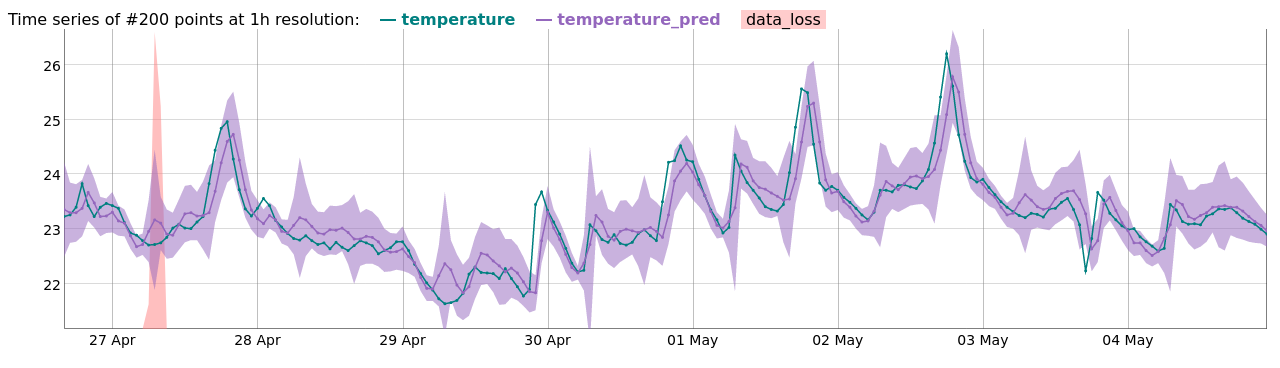

In [21]:
evaluation['series'][200:400].plot(data_labels=['temperature', 'temperature_pred'])